In [120]:
input('Warning: contains solution spoilers. Press enter to continue.')
import numpy as np
import matplotlib.pyplot as plt
import time

# Problem set 8

## Question 1

Consider the central difference discretisation of $\nabla^2\phi = f$. The matrix $M$ such that $M\phi = f$ is the tridiagonal matrix $$M=\frac{1}{(\Delta x)^2}\begin{bmatrix} -2 & 1 & 0&\cdots \\ 1 & -2 & 1 & \cdots\\\vdots&\ddots&\ddots&\cdots\end{bmatrix}.$$ Set boundaries 0 explicitly.

Jacobi is given by the splitting $D + (U+L)$, where $D=\mathrm{diag}\ M$ and $U$, $L$ denotes the strictly upper and lower parts. Thus we have the diagonal of $-2$ and $(U+L)$ tri-banded $(1,0,1)$.

Gauss-sidel is given by the splitting $U + (D+L)$, with $U$ off-diagonal 1 and $(D+L)$ banded $(1,-2,0)$.

In [121]:
def jacobi(f_dx, iter=100000, tol=1e-8):
    '''solve Mphi=(f*dx^2)'''
    res = []
    phi = np.zeros_like(f_dx)
    phi_next = np.zeros_like(phi)
    for _ in range(iter):
        res.append(np.linalg.norm(f_dx[1:-1] - np.diff(phi, 2)))
        phi_next[1:-1] = 1/-2 * (f_dx[1:-1] - phi[2:] - phi[:-2])
        if res[-1] < tol:
            break
        phi[:] = phi_next
    else:
        print(f'Warning: did not converge in {iter} iterations.')
    return phi, res

In [122]:
def gauss_seidel(f_dx, iter=30000, tol=1e-8):
    '''solve Mphi=(f*dx^2)'''
    res = []
    phi = np.zeros_like(f_dx)
    for _ in range(iter):
        res.append(np.linalg.norm(f_dx[1:-1] - np.diff(phi, 2)))
        for i in range(1, len(phi)-1):
            phi[i] = 1/-2 * (f_dx[i] - phi[i+1] - phi[i-1])
        if res[-1] < tol:
            break
    else:
        print(f'Warning: did not converge in {iter} iterations.')
    return phi, res

In [123]:
def sor(f_dx, omega=.5, iter=30000, tol=1e-8):
    '''solve Mphi=(f*dx^2)'''
    res = []
    phi = np.zeros_like(f_dx)
    for _ in range(iter):
        res.append(np.linalg.norm(f_dx[1:-1] - np.diff(phi, 2)))
        for i in range(1, len(phi)-1):
            phi[i] = (1-omega)*phi[i] + omega/-2 * (f_dx[i] - phi[i+1] - phi[i-1])
        if res[-1] < tol:
            break
    else:
        print(f'Warning: did not converge in {iter} iterations.')
    return phi, res

Test problem: solve $$\nabla^2 \phi = -100x(1-x)$$ on $0\leq x\leq 1$ with $\phi(0)=\phi(1)=0$ as in PS5. The exact solution is $\phi(x) = \frac{25}3(x^4 - 2 x^3 + x)$.

In [124]:
def test_method(fn, x, f):
    start = time.time()
    dx = x[1] - x[0]
    phi, res = fn(f(x)*dx**2)
    return phi, res, time.time() - start

def plot_methods(fns, n):
    f = lambda x: -100*x*(1-x)
    phi_exact = lambda x: 25/3*(x**4-2*x**3+x)
    x = np.linspace(0, 1, n)
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    for name, fn in fns.items():
        phi, res, time = test_method(fn, x, f)
        axs[0].plot(x, phi, label=name)
        axs[1].plot(res, label=name)
        print(f'{name}: {time:.2f}s')
    axs[0].set_title('phi')
    axs[1].set_title('residual')
    axs[0].plot(x, phi_exact(x), '--', label='exact')
    axs[0].legend()
    axs[1].legend()
    axs[1].set_yscale('log')
    plt.show()

jacobi: 0.19s
gauss_seidel: 0.40s
sor 1.95: 0.01s
sor 1.5: 0.19s
sor 1.99: 0.07s


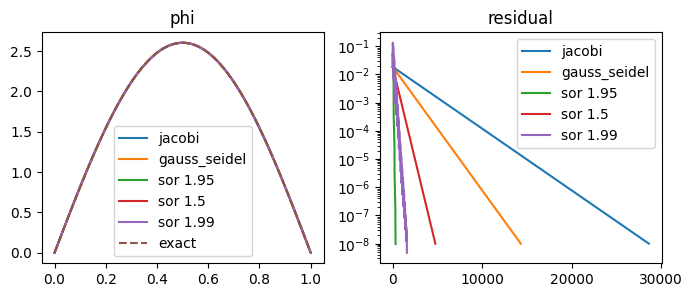

In [125]:
import functools
fns = {'jacobi': jacobi,
       'gauss_seidel': gauss_seidel,
       'sor 1.95': functools.partial(sor, omega=1.95),
       'sor 1.5': functools.partial(sor, omega=1.5),
       'sor 1.99': functools.partial(sor, omega=1.99),}
n = 100

plot_methods(fns, n)

Comment: Gauss-Seidel converges faster, but the implementation here is slower due to the `for` loop (we could perhaps vectorise). SOR is the best.

### Comparson to direct methods

In [126]:
# Get code from previous notebook to compare
# Might take a wee while
## !pip install import-ipynb
import import_ipynb
from ps7 import gaussian_elimination, LU_decomposition
from ps7 import test_methods as _test_methods
from ps7 import plot_methods as _plot_methods

In [127]:
def jacobi_test(A, b):
    phi, _ = jacobi(b, tol=1e-15)
    return phi

def gauss_seidel_test(A, b):
    phi, _ = gauss_seidel(b, tol=1e-15)
    return phi

def sor_test(A, b):
    phi, _ = sor(b, omega=1.68, tol=1e-15)
    return phi

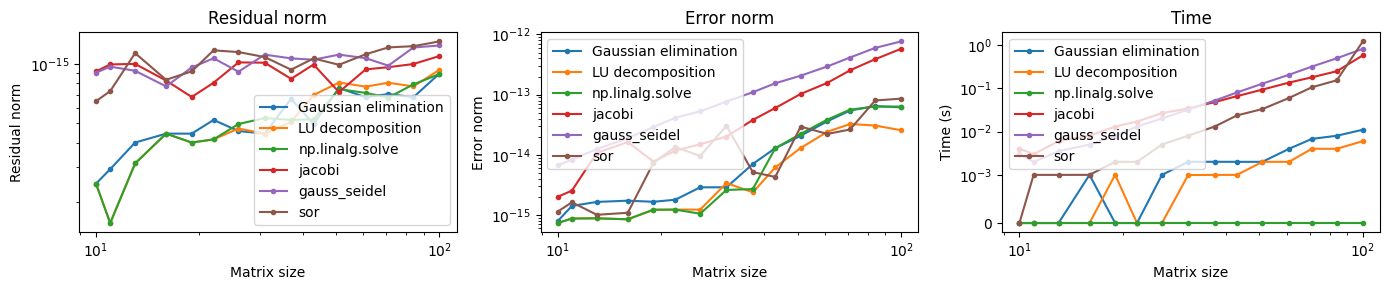

In [128]:
n_list = np.logspace(1, 2, 15, dtype=int)
fns = {'Gaussian elimination': gaussian_elimination,
       'LU decomposition': LU_decomposition,
       'np.linalg.solve': np.linalg.solve,
       'jacobi': jacobi_test,
       'gauss_seidel': gauss_seidel_test,
       'sor': sor_test,}

def A_n(n):
       A = np.diag(-2*np.ones(n)) + np.diag(np.ones(n-1), 1) + np.diag(np.ones(n-1), -1)
       A[0, 0] = A[-1, -1] = 1
       A[0, 1] =  A[-1, -2] = 0
       return A
def b_n(n):
       np.random.seed(0)
       b = np.random.rand(n)
       b[0] = b[-1] = 0
       return b

res, err, t = _test_methods(fns, n_list, trys=1, A_n=A_n, x_sol_n=b_n)
_plot_methods(fns, res, err, t, n_list)

In this case, direct solvers seem to give better results than iterative solvers (since matrix size is small and we set a small residual tolerance). SOR seems to do the best out of the three iterative solvers.

## Question 2

In [129]:
def jacobi_2(A, b, iter=100000, tol=1e-15):
    '''solve Ax=b'''
    phi = np.zeros_like(b)
    phi_next = np.zeros_like(phi)
    D = np.diag(np.diag(A))
    R = A - D
    Dinv = np.diag(1/np.diag(D))
    for _ in range(iter):
        res = np.linalg.norm(b - A @ phi)
        phi_next = Dinv @ (b - R @ phi)
        if res < tol:
            break
        phi[:] = phi_next
    else:
        print(f'Warning: did not converge in {iter} iterations.')
    return phi

In [130]:
def gauss_seidel_2(A, b, iter=30000, tol=1e-15):
    '''solve Ax=b'''
    phi = np.zeros_like(b)
    L = np.tril(A, 0)
    U = np.triu(A, 1)
    Linv = np.linalg.inv(L)
    for _ in range(iter):
        res = np.linalg.norm(b - A @ phi)
        # phi = np.linalg.solve(L, b - U @ phi)
        phi = Linv @ (b - U @ phi)
        if res < tol:
            break
    else:
        print(f'Warning: did not converge in {iter} iterations.')
    return phi

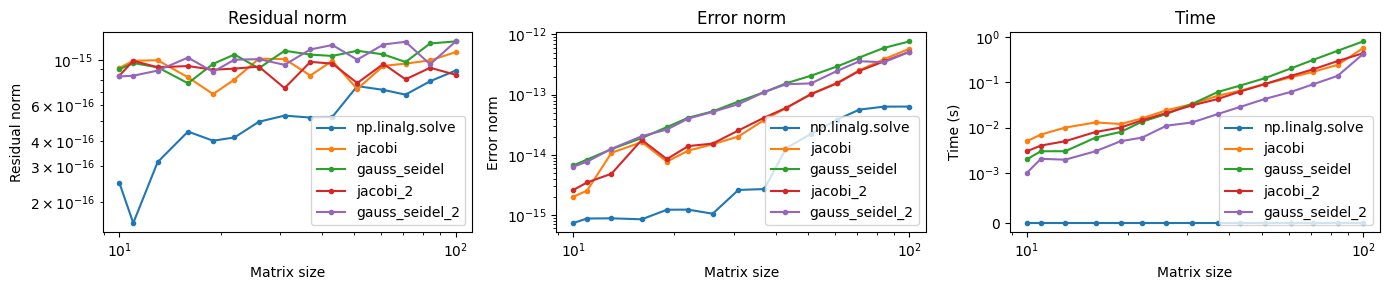

In [131]:
n_list = np.logspace(1, 2, 15, dtype=int)
fns = {#'Gaussian elimination': gaussian_elimination,
       #'LU decomposition': LU_decomposition,
       'np.linalg.solve': np.linalg.solve,
       'jacobi': jacobi_test,
       'gauss_seidel': gauss_seidel_test,
       #'sor': sor_test,
       'jacobi_2': jacobi_2,
       'gauss_seidel_2': gauss_seidel_2,}

def A_n(n):
       A = np.diag(-2*np.ones(n)) + np.diag(np.ones(n-1), 1) + np.diag(np.ones(n-1), -1)
       A[0, 0] = A[-1, -1] = 1
       A[0, 1] =  A[-1, -2] = 0
       return A
def b_n(n):
       np.random.seed(0)
       b = np.random.rand(n)
       b[0] = b[-1] = 0
       return b

res, err, t = _test_methods(fns, n_list, trys=1, A_n=A_n, x_sol_n=b_n)
_plot_methods(fns, res, err, t, n_list)

These new methods are slightly faster than the previous iterative methods because we are storing inverses.


Testing against direct methods with an arbitary matrix...


In [132]:
def jacobi_2_test(A, b):
    n = len(b)
    phi = jacobi_2(A, b, tol=1e-14*n)
    return phi

def gauss_seidel_2_test(A, b):
    n = len(b)
    phi = gauss_seidel_2(A, b, tol=1e-14*n)
    return phi

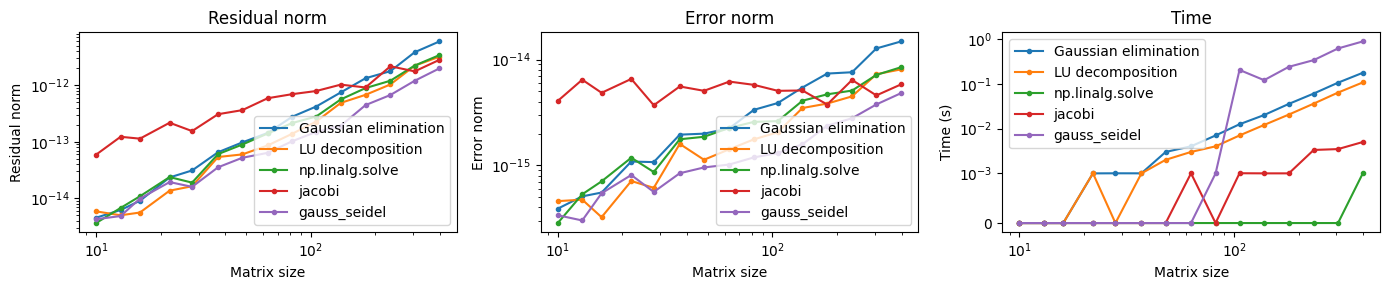

In [133]:
n_list = np.logspace(1, 2.6, 15, dtype=int)

fns = {'Gaussian elimination': gaussian_elimination,
       'LU decomposition': LU_decomposition,
       'np.linalg.solve': np.linalg.solve,
       'jacobi': jacobi_2_test,
       'gauss_seidel': gauss_seidel_2_test,}

def A_n(n):
    np.random.seed(n)
    A = np.random.rand(n, n) 
    A += np.diag(n*np.ones(n))   
    return A

res, err, t = _test_methods(fns, n_list, trys=1, A_n=A_n)
_plot_methods(fns, res, err, t, n_list)

We've made the tolerences larger as $n$ increases for the iterative methods so that they approximately follow the direct methods. Note that Gauss Seidel is quite slow for large matrices because of the matrix inversion. Jacobi does not need inversion (since the inverse of a diagonal matrix is trivial to compute).

We can compare Jacobi to direct methods for large matrices...

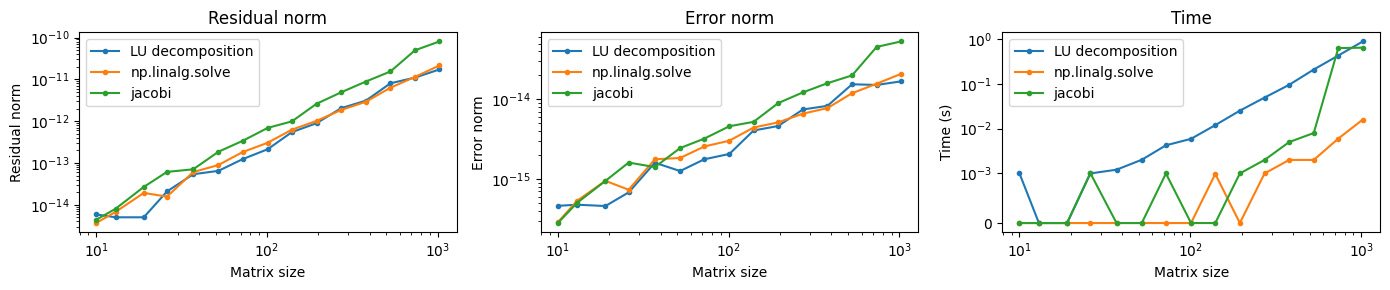

In [140]:
n_list = np.logspace(1, 3.01, 15, dtype=int)

def jacobi_2_test2(A, b):
    n = len(b)
    phi = jacobi_2(A, b, tol=1e-16*n**2)
    return phi

fns = {'LU decomposition': LU_decomposition,
       'np.linalg.solve': np.linalg.solve,
       'jacobi': jacobi_2_test2,}

def A_n(n):
    np.random.seed(n)
    A = np.random.rand(n, n) 
    A += np.diag(n*np.ones(n))   
    return A

res, err, t = _test_methods(fns, n_list, trys=1, A_n=A_n)
_plot_methods(fns, res, err, t, n_list)

Jacobi does quite well! Tweaking the tols can make this a viable alternative depending on the problem.